### Surface signal for 8Tr in Astoria and Barkley bathymetries

In [2]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import matplotlib as mpl
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg
import xarray as xr
import matplotlib.gridspec as gspec

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [4]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [5]:
def PlotSurfTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, ptr_fileANoC, ptr_fileBNoC, grid_fileA, grid_fileB,
                xslice_pl, yslice_pl, nz,
                hFacA, rAA, DepthA, XA, YA,
                hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200, vmin=-0.2, vmax=0.2):
    
    sns.set_style('white')
    with Dataset(ptr_fileA, 'r') as nbl:
        ConcLinA = np.mean(nbl.variables[key][tt,:4,:,:], axis=0)
    with Dataset(ptr_fileANoC, 'r') as nbl:
        ConcLinANoC = np.mean(nbl.variables[key][tt,:4,:,:], axis=0)
        
    mesh1 = ax1.contourf(XA, YA, (ConcLinA-ConcLinANoC)/ConcLinANoC,20,
                        cmap=cmo.cm.tarn_r, vmin=vmin, vmax=vmax)

    plt.colorbar(mesh1, ax=ax1)
    
    with Dataset(grid_fileA, 'r') as nbl:
        bathy = nbl.variables['Depth'][:]
    ax1.contour(XA, YA, bathy,levels=[-sbdepthA],colors=['0.4'])

    with Dataset(ptr_fileB, 'r') as nbl:
        ConcLinB = np.mean(nbl.variables[key][tt,:4,:,:], axis=0)
    with Dataset(ptr_fileBNoC, 'r') as nbl:
        ConcLinBNoC = np.mean(nbl.variables[key][tt,:4,:,:], axis=0)
        
    mesh2 = ax2.contourf(XB, YB, (ConcLinB-ConcLinBNoC)/ConcLinBNoC, 20,
                        cmap=cmo.cm.tarn_r, vmin=vmin, vmax=vmax)

    plt.colorbar(mesh2, ax=ax2)
    
    with Dataset(grid_fileB, 'r') as nbl:
        bathyB = nbl.variables['Depth'][:]
    ax2.contour(XB, YB, bathyB,levels=[-sbdepthB],colors=['0.4'])
   
    for ax in [ax1,ax2]:
        ax.set_facecolor("darkgrey")
        ax.set_ylabel('Cross-shelf / km')

    ax1.set_xlabel('CS distance / km')
    ax1.set_title('Astoria')
    ax2.set_xlabel('CS distance / km')
    ax2.set_title('Barkley day %1.1f' %(tt/2))

    ax1.set_aspect(1)
    return(ax1, ax2)

def getProfile(ptracers_file, mask, trac, xind, yind, zslice, tt):
    
    with Dataset(ptracers_file, 'r') as nbl:
        
        tr = np.ma.masked_array(nbl.variables[trac][tt,zslice,yind,xind], mask = mask[zslice,yind,xind])
       
    return (tr)

def plot_head_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice, zsliceB, ZA, ZB):
    
    fig,ax = plt.subplots(2,3,figsize=(9,6))

    pal1 = sns.color_palette('Greens', 10)
    pal2 = sns.color_palette('Purples', 10)

    yindA = 230
    xindA = 230

    yindB = 160
    xindB = 218

    for ii in range(3):
        ax[0,ii].axhline(-20, color='0.8')

    for tt in range(0,19,2):
        
        tr = getProfile(ptr_fileA, maskCA, key, xindA, yindA, zslice, tt)
        trNoC = getProfile(ptr_fileANoC,maskCANoC, key, xindA, yindA, zslice, tt)
        ax[0,1].plot(trNoC, ZA[zslice],color=pal1[int(tt/2)], label='%d' %(tt/2))
        ax[0,2].plot(tr-trNoC, ZA[zslice],color=pal1[int(tt/2)], label='%d' %(tt/2))
        ax[0,0].plot(tr, ZA[zslice],color=pal1[int(tt/2)], label='%d' %(tt/2))
    
    ax[0,2].set_title('Canyon-No Canyon')
    ax[0,0].set_title('%s Astoria canyon' %key)
    ax[0,1].set_title('Shelf only')
    ax[0,0].set_ylabel('Depth / m')
    
    for ii in range(3):
        ax[1,ii].axhline(-20, color='0.8')

    for tt in range(0,19,2):
        tr = getProfile(ptr_fileB, maskCB,key, xindB, yindB, zsliceB, tt)
        ax[1,0].plot(tr, ZB[zsliceB],color=pal2[int(tt/2)], label='%d' %(tt/2))
        trNoC = getProfile(ptr_fileBNoC,maskCBNoC, key, xindB, yindB, zsliceB, tt)
        ax[1,1].plot(trNoC, ZB[zsliceB],color=pal2[int(tt/2)], label='%d' %(tt/2))
        ax[1,2].plot(tr-trNoC, ZB[zsliceB],color=pal2[int(tt/2)], label='%d' %(tt/2))
    
    ax[1,2].set_xlabel('Concentration/%s' %units)    
    ax[1,0].set_title('Barkley canyon')
    ax[1,0].set_ylabel('Depth / m')
    ax[1,0].set_xlabel('Concentration/%s' %units)
    ax[1,1].set_xlabel('Concentration/%s' %units)
    
    ax[0,2].legend(bbox_to_anchor=(1,1))   
    ax[1,2].legend(bbox_to_anchor=(1,1))

In [6]:
ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_8TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_8TR_BF4_BAR/01_Bar03/gridGlob.nc'
ptr_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_8TR_BF4_BAR/02_Bar03_No_Cny/ptracersGlob.nc'
grid_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_8TR_BF4_BAR/02_Bar03_No_Cny/gridGlob.nc'

ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_8TR_BF2_AST/01_Ast03/ptracersGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_8TR_BF2_AST/01_Ast03/gridGlob.nc'
ptr_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_8TR_BF2_AST/02_Ast03_No_Cny/ptracersGlob.nc'
grid_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_8TR_BF2_AST/02_Ast03_No_Cny/gridGlob.nc'


In [7]:
nz = 104
sb_Ast = 30 # shelf break z-index Astoria
sb_Bar = 40 # shelf break z-index Barkley

with Dataset(grid_fileB, 'r') as nbl:
    ZB = nbl.variables['RC'][:]
    YB = nbl.variables['Y'][:]
    XB = nbl.variables['X'][:]
    hFacB = nbl.variables['HFacC'][:]
    DepthB = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacB, 0)
    maskCB = np.ma.getmask(hfac)
    rAB = nbl.variables['rA'][:]

with Dataset(grid_fileBNoC, 'r') as nbl:
    hFacBNoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacBNoC, 0)
    maskCBNoC = np.ma.getmask(hfacNoC)
    
with Dataset(grid_fileA, 'r') as nbl:
    ZA = nbl.variables['RC'][:]
    YA = nbl.variables['Y'][:]
    XA = nbl.variables['X'][:]
    hFacA = nbl.variables['HFacC'][:]
    DepthA = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacA, 0)
    maskCA = np.ma.getmask(hfac)
    rAA = nbl.variables['rA'][:]
    
with Dataset(grid_fileANoC, 'r') as nbl:
    hFacANoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacANoC, 0)
    maskCANoC = np.ma.getmask(hfacNoC)
   

### 01 - Initial profiles

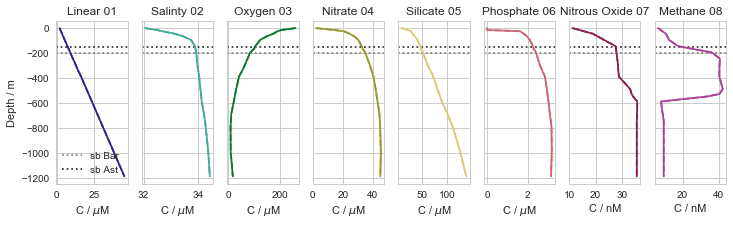

In [8]:
tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08']
#colours = ['purple','blue','green','gold','orange','red','orchid','teal']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499']
fig,ax = plt.subplots(1,len(tracers),figsize=(12,3), sharey = True)
    
for ii, trac, col, lab in zip(range(len(tracers)),tracers , colours, labels):

    ax[ii].axhline(-200, linestyle=':', color='0.5', label='sb Bar')
    ax[ii].axhline(-150, linestyle=':', color='0.2', label='sb Ast')
    
    for pfile, Z, style in zip([ptr_fileB, ptr_fileA],[ZB, ZA],['-', '--']):
        
        with Dataset(pfile, 'r') as nbl:
            tr_profile = nbl.variables[trac][0,:,10,180]

        ax[ii].plot(tr_profile, Z, color=col,linestyle=style)
        ax[ii].set_title(lab)
        
        if (trac == 'Tr07' or trac == 'Tr08'):
            ax[ii].set_xlabel('C / nM')
        else:
            ax[ii].set_xlabel(r'C / $\mu$M')

ax[0].set_ylabel('Depth / m')        
ax[0].legend(loc=0)

Initial profiles. Profiles for both runs plotted to check they are actually the same.

#### Vertical tracer gradient

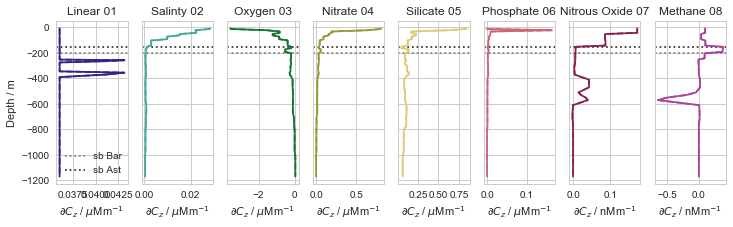

In [9]:
tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08']

dTr_Ast = np.empty(len(tracers))
dTr_Bar = np.empty(len(tracers))

fig,ax = plt.subplots(1,len(tracers),figsize=(12,3), sharey = True)
    
for ii, trac, col, lab in zip(range(len(tracers)),tracers , colours, labels):

    ax[ii].axhline(-200, linestyle=':', color='0.5', label='sb Bar')
    ax[ii].axhline(-150, linestyle=':', color='0.2', label='sb Ast')
    
    for pfile, Z, style in zip([ptr_fileB, ptr_fileA],[ZB, ZA],['-', '--']):
        
        with Dataset(pfile, 'r') as nbl:
            tr_profile = nbl.variables[trac][0,:,10,180]
            dTrdz = (tr_profile[2:]-tr_profile[:-2])/(-Z[2:]+Z[:-2])  
            dTr_Ast[ii] = dTrdz[sb_Ast]
            dTr_Bar[ii] = dTrdz[sb_Bar]
            
        ax[ii].plot(dTrdz, Z[1:-1], color=col,linestyle=style)
        ax[ii].set_title(lab)
        
        if (trac == 'Tr07' or trac == 'Tr08'):
            ax[ii].set_xlabel('$\partial C_z$ / nMm$^{-1}$')
        else:
            ax[ii].set_xlabel(r'$\partial C_z$ / $\mu$Mm$^{-1}$')

ax[0].set_ylabel('Depth / m')        
ax[0].legend(loc=0)

### 02 - Surface anomaly

Linear tracer (Tr01) 

Tracer gradients below shelf-break depth are the same for both canyons. This is the "base case" pool where both canyons have the same N,f, almost same U, and same dTr/dz at shelf-break depth.

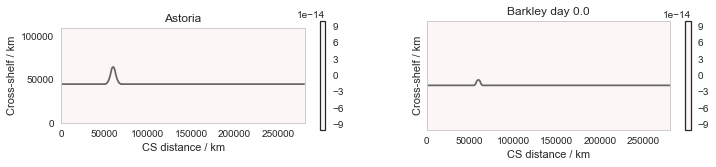

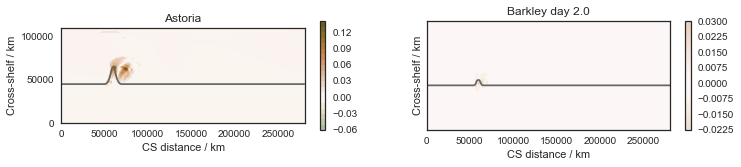

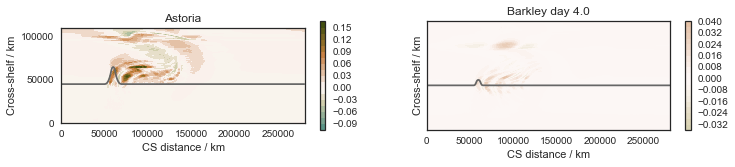

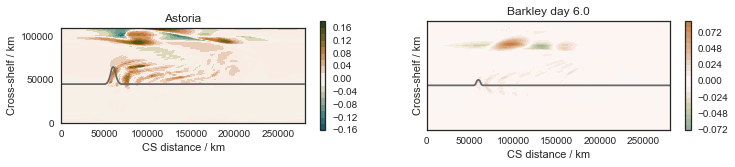

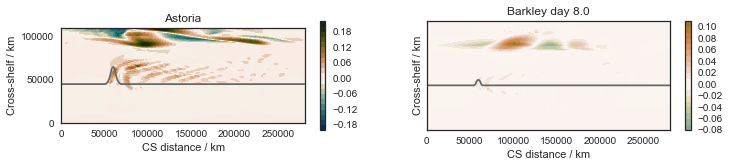

In [10]:
yslice_pl = slice(110,360)
xslice_pl = slice(120,500)

key = 'Tr01'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotSurfTr (ax1, ax2, tt, key, ptr_fileA, ptr_fileB, ptr_fileANoC, ptr_fileBNoC, grid_fileA, grid_fileB,
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
    

Salinity (Tr02)

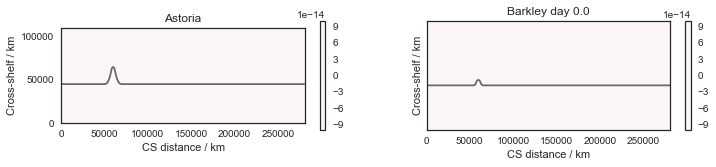

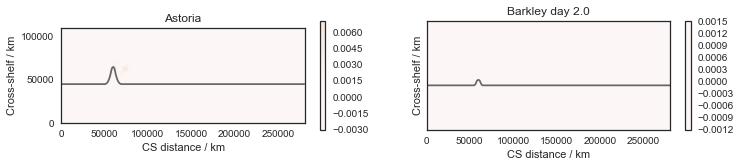

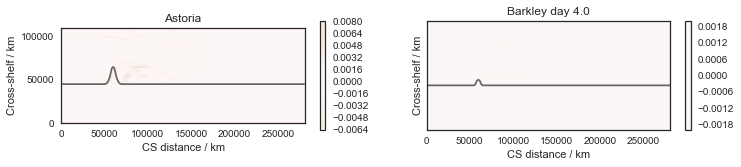

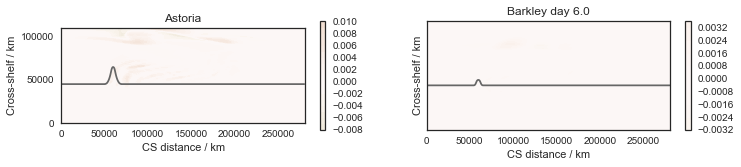

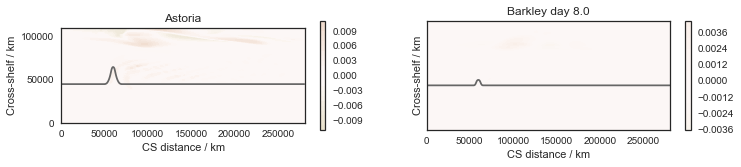

In [11]:
yslice_pl = slice(110,360)
xslice_pl = slice(120,500)

key = 'Tr02'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotSurfTr (ax1, ax2, tt, key, ptr_fileA, ptr_fileB, ptr_fileANoC, ptr_fileBNoC,grid_fileA, grid_fileB,
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200, vmin=-0.1, vmax=0.1)
  

#### Oxygen

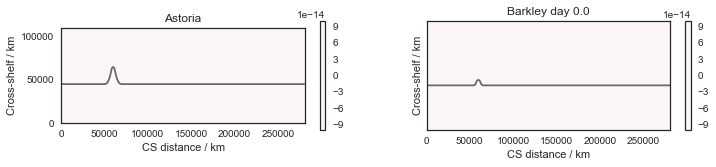

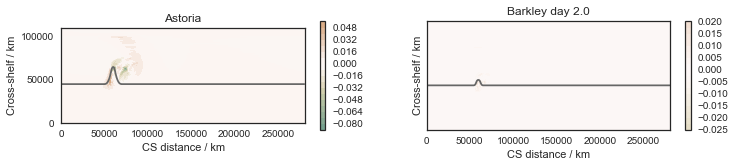

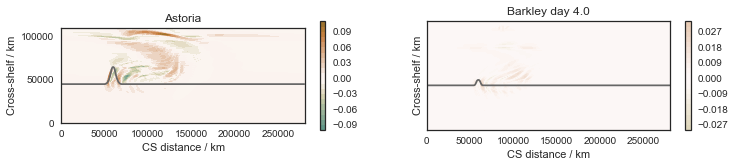

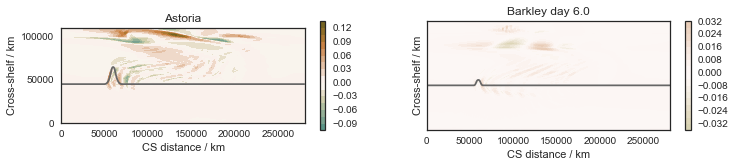

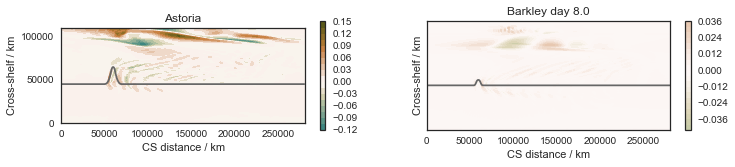

In [12]:
yslice_pl = slice(110,360)
xslice_pl = slice(120,500)

key = 'Tr03'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotSurfTr (ax1, ax2, tt, key, ptr_fileA, ptr_fileB, ptr_fileANoC, ptr_fileBNoC,grid_fileA, grid_fileB,
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
  

#### Nitrate

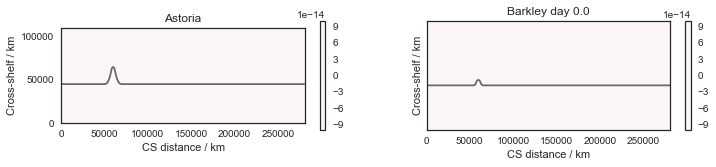

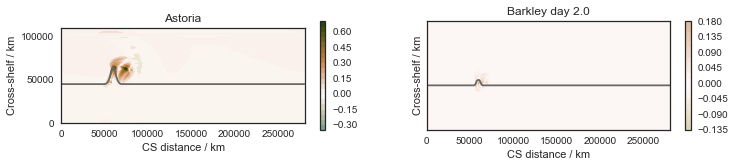

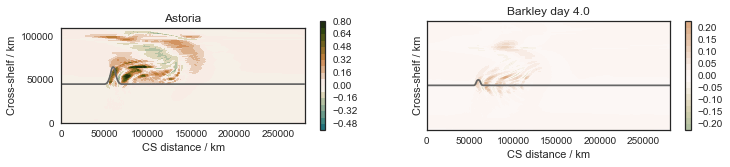

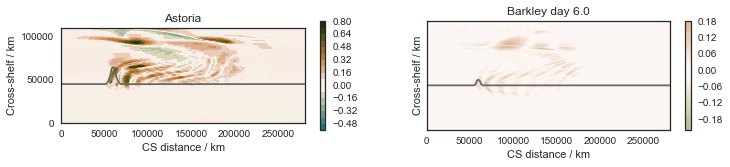

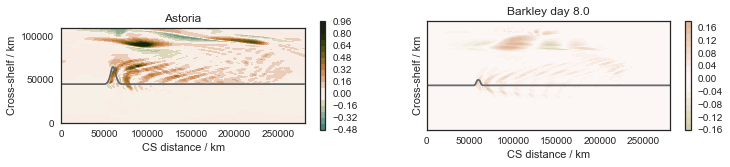

In [13]:
yslice_pl = slice(110,360)
xslice_pl = slice(120,500)

key = 'Tr04'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotSurfTr (ax1, ax2, tt, key, ptr_fileA, ptr_fileB, ptr_fileANoC, ptr_fileBNoC,grid_fileA, grid_fileB,
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200, vmin=-0.8, vmax=0.8)
  

#### Silicate

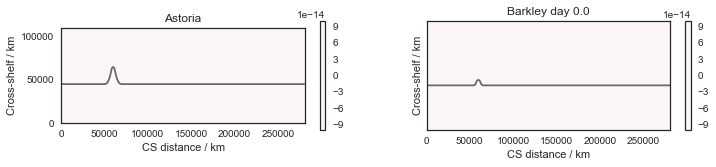

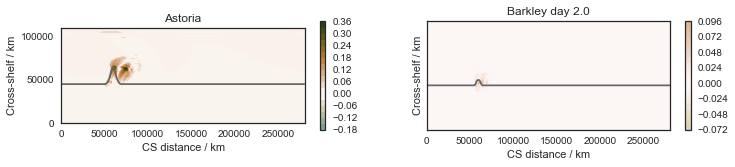

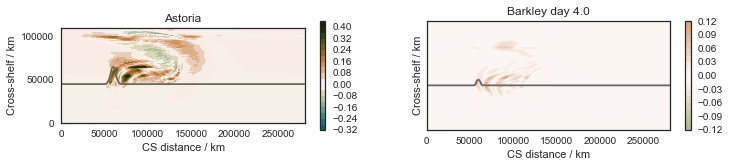

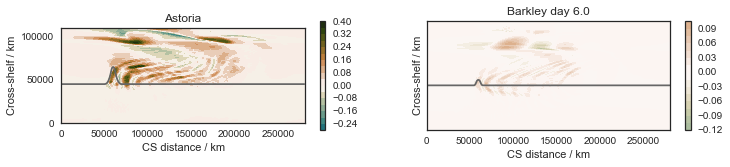

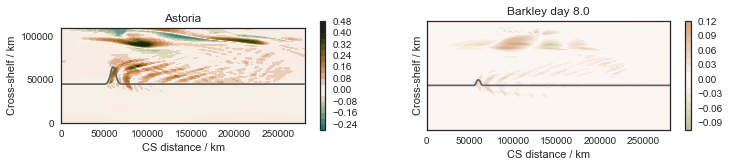

In [14]:
yslice_pl = slice(110,360)
xslice_pl = slice(120,500)

key = 'Tr05'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotSurfTr (ax1, ax2, tt, key, ptr_fileA, ptr_fileB, ptr_fileANoC, ptr_fileBNoC,grid_fileA, grid_fileB,
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200, vmin=-0.4, vmax=0.4)
  

#### Phosphate - dividing by a small number is baaad. See bottom plots

/home/kramosmu/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


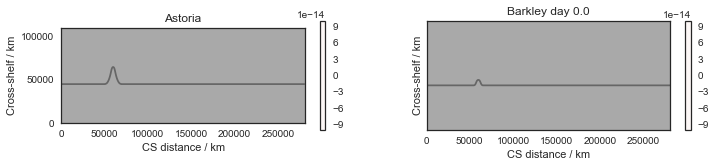

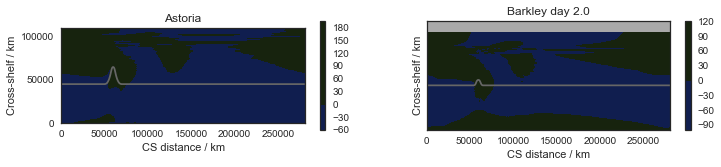

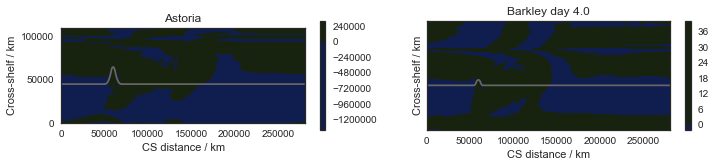

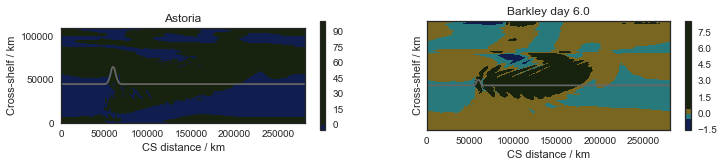

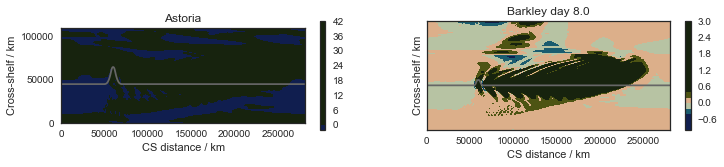

In [15]:
yslice_pl = slice(110,360)
xslice_pl = slice(120,500)

key = 'Tr06'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotSurfTr (ax1, ax2, tt, key, ptr_fileA, ptr_fileB, ptr_fileANoC, ptr_fileBNoC,grid_fileA, grid_fileB,
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200, vmin=-0.4, vmax=0.4)
 

#### Nitrous Oxide

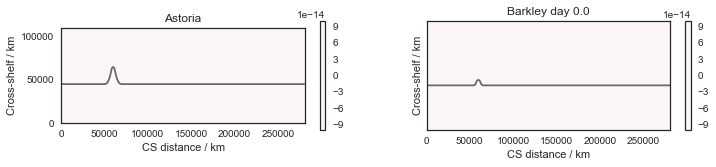

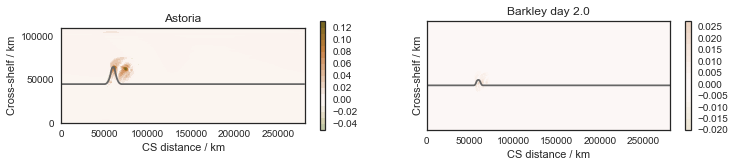

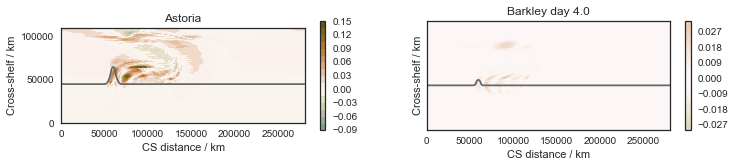

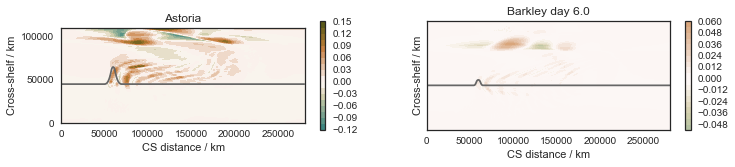

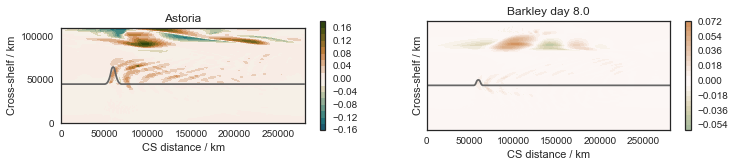

In [16]:
yslice_pl = slice(110,360)
xslice_pl = slice(120,500)

key = 'Tr07'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotSurfTr (ax1, ax2, tt, key, ptr_fileA, ptr_fileB, ptr_fileANoC, ptr_fileBNoC,grid_fileA, grid_fileB,
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200, vmin=-0.2, vmax=0.2)
  

#### Methane

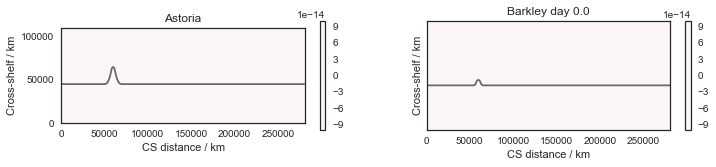

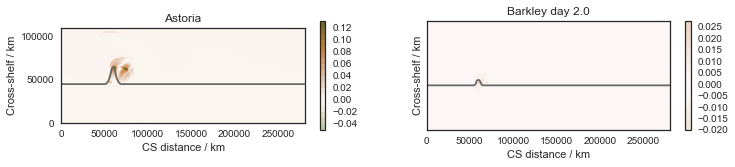

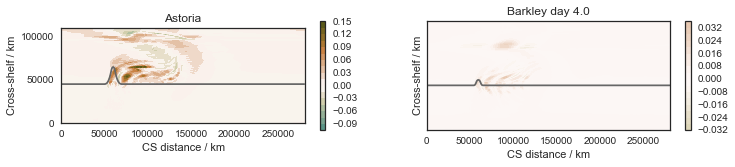

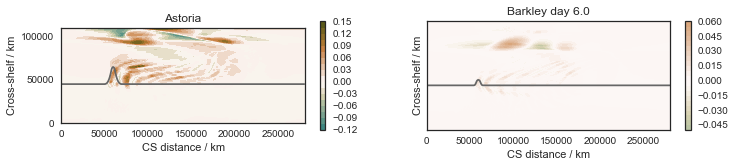

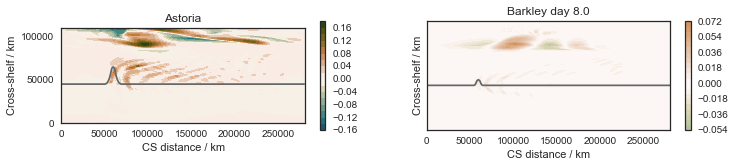

In [17]:
yslice_pl = slice(110,360)
xslice_pl = slice(120,500)

key = 'Tr08'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotSurfTr (ax1, ax2, tt, key, ptr_fileA, ptr_fileB, ptr_fileANoC, ptr_fileBNoC,grid_fileA, grid_fileB,
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200, vmin=-0.2, vmax=0.2)
  

#### Phosphate anomaly (without rescaling because initial concentrations are very small)

Text(0.5,1,'canyon-no canyon, Anomaly / $\\mu$M')

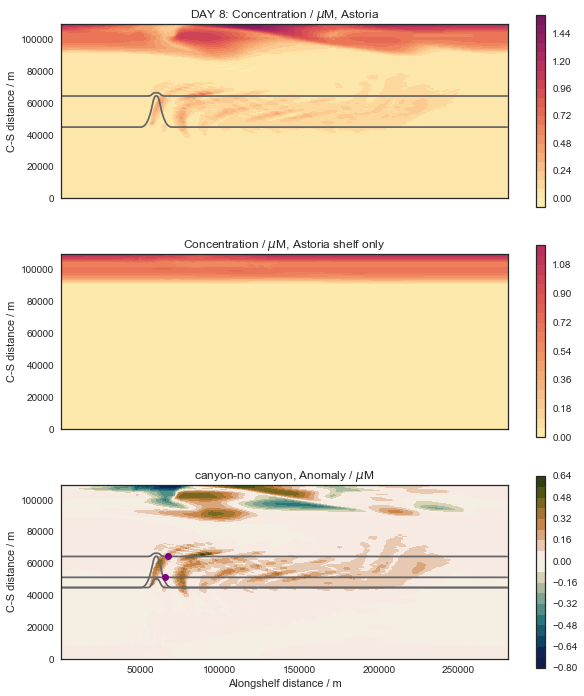

In [18]:
fig,(ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,12), sharex=True) 

key = 'Tr06'
tt = 14
with Dataset(ptr_fileA, 'r') as nbl:
    ConcLinA = np.mean(nbl.variables[key][tt,:4,:,:], axis=0)
mesh1 = ax1.contourf(XA, YA, ConcLinA,20, cmap=cmo.cm.matter, vmin=0, vmax=2)
plt.colorbar(mesh1, ax=ax1)

with Dataset(grid_fileA, 'r') as nbl:
    bathy = nbl.variables['Depth'][:]
ax1.contour(XA, YA, bathy,levels=[105,150],colors=['0.4'])
   
with Dataset(ptr_fileANoC, 'r') as nbl:
    ConcLinANoC = np.mean(nbl.variables[key][tt,:4,:,:], axis=0)

mesh2 = ax2.contourf(XA, YA, ConcLinANoC,20,
                     cmap=cmo.cm.matter, vmin=0, vmax=2)
plt.colorbar(mesh2, ax=ax2)

mesh3 = ax3.contourf(XA, YA, (ConcLinA-ConcLinANoC),20,
                     cmap=cmo.cm.tarn_r, vmin=-0.7, vmax=0.7)
plt.colorbar(mesh3, ax=ax3)
ax3.contour(XA, YA, bathy,levels=[105,150],colors=['0.4'])

with Dataset(grid_fileB, 'r') as nbl:
    bathyB = nbl.variables['Depth'][:]
ax3.contour(XB, YB, bathyB,levels=[170,200],colors=['0.4'])
ax3.plot(XA[230], YA[230],'o', color='purple')
ax3.plot(XA[218], YA[160],'o', color='purple')

ax1.set_aspect(1)        
ax2.set_aspect(1)        
ax3.set_aspect(1)        

ax3.set_xlabel('Alongshelf distance / m')
ax1.set_ylabel('C-S distance / m')
ax2.set_ylabel('C-S distance / m')
ax3.set_ylabel('C-S distance / m')

ax1.set_title('DAY 8: Concentration / $\mu$M, Astoria')
ax2.set_title('Concentration / $\mu$M, Astoria shelf only')
ax3.set_title('canyon-no canyon, Anomaly / $\mu$M')

### Take-aways

* Barkley's near-surface anomaly signal is weaker than for Astoria for all tracers. Barkely's shelf break is 50 m deeper than Astoria's.

* For all tracers, positive-negative anomaly band close to northern boundary, where depth is 20m. In Barkley, the signal is weaker and closer to shelf break, where bathy becomes 20 m.

* For all tracers, positive anomaly above canyon location that travels downstream. Can be as large as 80% for nitrate in Astoria but around 20% for other tracers. Positive-negative bands for Oxygen.


## Profiles near downstream side of the canyon head

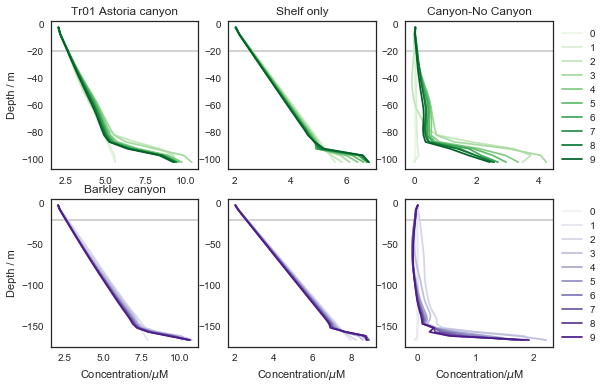

In [19]:
key = 'Tr01'
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$\mu$M'

plot_head_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice, zsliceB, ZA, ZB)

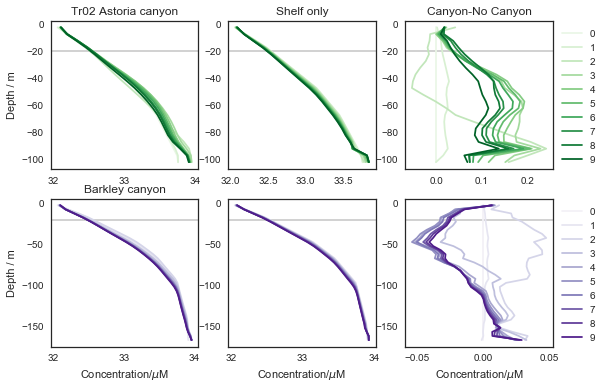

In [20]:
key = 'Tr02'
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$\mu$M'

plot_head_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice, zsliceB, ZA, ZB)

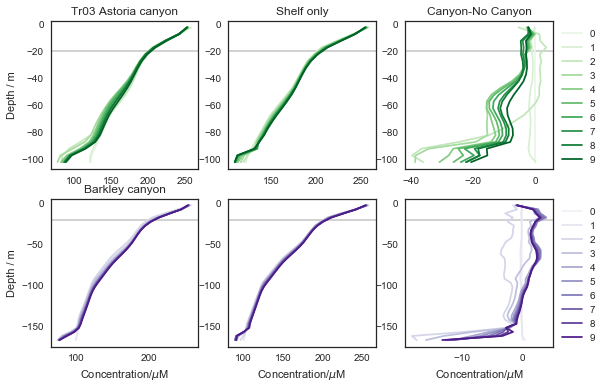

In [21]:
key = 'Tr03'
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$\mu$M'

plot_head_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice, zsliceB, ZA, ZB)

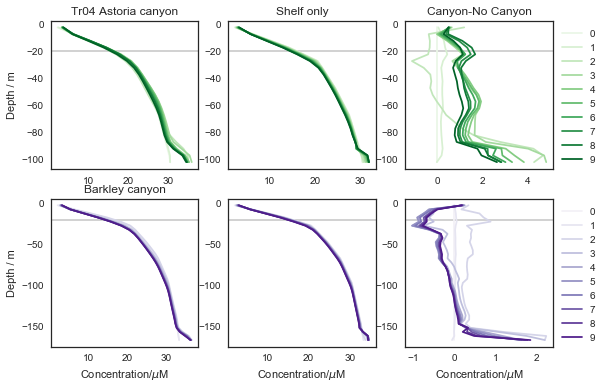

In [22]:
key = 'Tr04'
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$\mu$M'

plot_head_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice, zsliceB, ZA, ZB)

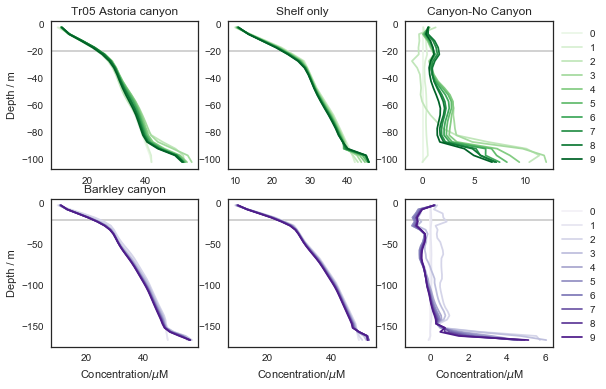

In [23]:
key = 'Tr05'
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$\mu$M'

plot_head_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice, zsliceB, ZA, ZB)

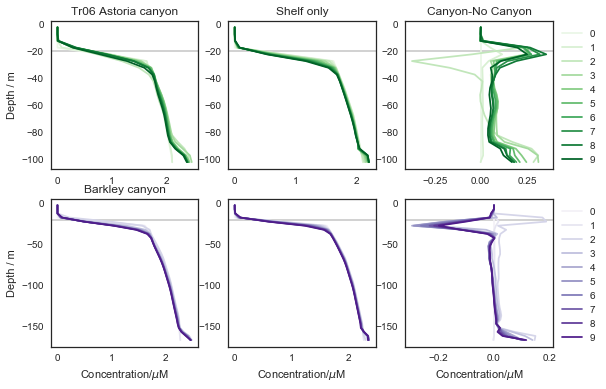

In [24]:
key = 'Tr06'
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$\mu$M'

plot_head_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice, zsliceB, ZA, ZB)

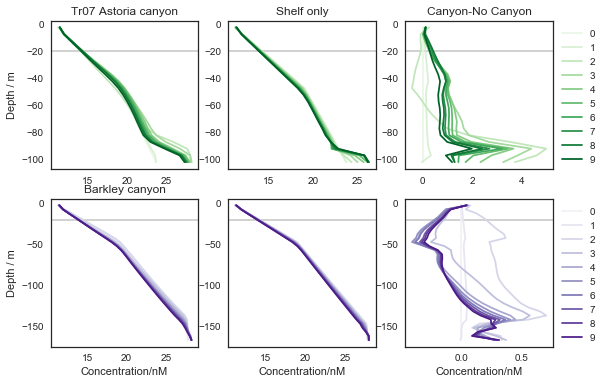

In [25]:
key = 'Tr07'
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'nM'

plot_head_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice, zsliceB, ZA, ZB)

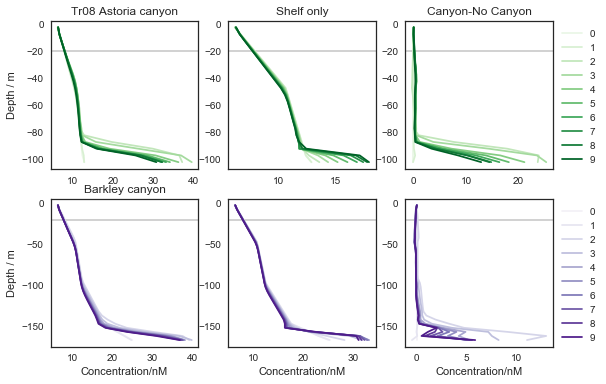

In [26]:
key = 'Tr08'
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'nM'

plot_head_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice, zsliceB, ZA, ZB)

### Near-surface mean anomaly 

Averages over an area 5$Wm$ and 2$L$

Text(0.5,1,'Barkley')

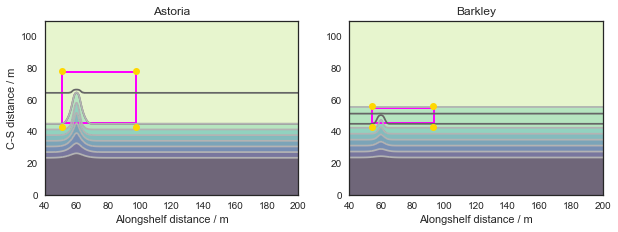

In [27]:
Wm_A = 15.7 # km
L_A = 21.8 # km

Wm_B = 13.0 # km
L_B = 6.4 # km


fig,(ax1, ax2) = plt.subplots(1,2,figsize=(10,4)) 

with Dataset(grid_fileA, 'r') as nbl:
    bathy = nbl.variables['Depth'][:]
ax1.contour(XA/1000, YA/1000, bathy,levels=[105,150],colors=['0.4'])
ax1.contourf(XA/1000, YA/1000, bathy, 10, cmap=cmo.cm.deep, alpha=0.7)
ax1.contour(XA/1000, YA/1000, bathy, 10, colors='0.7')

with Dataset(grid_fileB, 'r') as nbl:
    bathyB = nbl.variables['Depth'][:]
ax2.contour(XB/1000, YB/1000, bathyB, levels=[170,200], colors=['0.4'])
ax2.contourf(XB/1000, YB/1000, bathyB, 10, cmap=cmo.cm.deep, alpha=0.7)
ax2.contour(XB/1000, YB/1000, bathyB, 10, colors='0.7')

rect = pat.Rectangle((XA[120]/1000,YA[130]/1000),
                      3*Wm_A,
                      1.5*L_A,
                     linewidth=2,edgecolor='magenta',facecolor='none')
ax1.add_patch(rect)

xA_left = 120
xA_right = 320
yA_bot = 120
yA_top = 280

ax1.plot([XA[xA_left]/1000,XA[xA_right]/1000,XA[xA_left]/1000,XA[xA_right]/1000],
         [YA[yA_bot]/1000,YA[yA_bot]/1000,YA[yA_top]/1000,YA[yA_top]/1000], 'o', color='gold')

rect2 = pat.Rectangle((XA[140]/1000,YA[130]/1000),
                      3*Wm_B,
                      1.5*L_B,
                     linewidth=2,edgecolor='magenta',facecolor='none')
ax2.add_patch(rect2)

xB_left = 140
xB_right = 310
yB_bot = 120
yB_top = 185

ax2.plot([XB[xB_left]/1000,XB[xB_right]/1000,XB[xB_left]/1000,XB[xB_right]/1000],
         [YB[yB_bot]/1000,YB[yB_bot]/1000,YB[yB_top]/1000,YB[yB_top]/1000], 'o', color='gold')

ax1.set_xlim(40,200)
ax2.set_xlim(40,200)

ax1.set_aspect(1)        
ax2.set_aspect(1)        

ax1.set_xlabel('Alongshelf distance / m')
ax2.set_xlabel('Alongshelf distance / m')
ax1.set_ylabel('C-S distance / m')

ax1.set_title('Astoria')
ax2.set_title('Barkley')


Text(0,0.5,'$(C-C_{nc})/C_{nc}$')

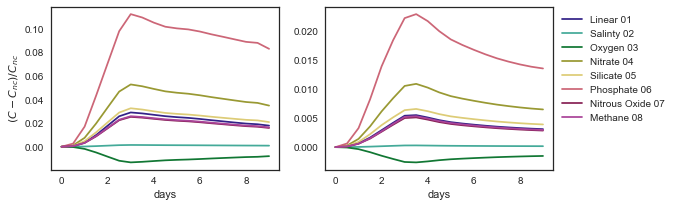

In [31]:
ptrA = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_8TR_BF2_AST/01_Ast03/ptracersGlob.nc')
ptrA_NoC = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_8TR_BF2_AST/02_Ast03_No_Cny/ptracersGlob.nc')
ptrB = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_8TR_BF4_BAR/01_Bar03/ptracersGlob.nc')
ptrB_NoC = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_8TR_BF4_BAR/02_Bar03_No_Cny/ptracersGlob.nc')

zsl = slice(0,8)
xslA = slice(xA_left, xA_right)
yslA = slice(yA_bot, yA_top)
xslB = slice(xB_left, xB_right)
yslB = slice(yB_bot, yB_top)

concA = [ptrA.Tr01.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
       ptrA.Tr02.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
       ptrA.Tr03.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
       ptrA.Tr04.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
       ptrA.Tr05.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
       ptrA.Tr06.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
       ptrA.Tr07.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z')*1E-3,
       ptrA.Tr08.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z')*1E-3] # units of nM to muM

concANoC = [ptrA_NoC.Tr01.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
           ptrA_NoC.Tr02.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
           ptrA_NoC.Tr03.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
           ptrA_NoC.Tr04.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
           ptrA_NoC.Tr05.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
           ptrA_NoC.Tr06.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
           ptrA_NoC.Tr07.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z')*1E-3,
           ptrA_NoC.Tr08.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z')*1E-3]

concB = [ptrB.Tr01.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
       ptrB.Tr02.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
       ptrB.Tr03.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
       ptrB.Tr04.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
       ptrB.Tr05.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
       ptrB.Tr06.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
       ptrB.Tr07.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z')*1E-3,
       ptrB.Tr08.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z')*1E-3]

concBNoC = [ptrB_NoC.Tr01.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
           ptrB_NoC.Tr02.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
           ptrB_NoC.Tr03.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
           ptrB_NoC.Tr04.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
           ptrB_NoC.Tr05.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
           ptrB_NoC.Tr06.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
           ptrB_NoC.Tr07.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z')*1E-3,
           ptrB_NoC.Tr08.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z')*1E-3]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,3), sharex=True)

for CA,CANoC,CB,CBNoC,col,lab in zip(concA, concANoC, concB, concBNoC, colours[:], labels[:]):
    #Astoria    
    anomA_ts = (((CA-CANoC)/CANoC).mean(dim='X')).mean(dim='Y')   
    ax1.plot(np.arange(len(anomA_ts))/2.0, anomA_ts, color=col, label=lab)
    
    #Barkley
    anomB_ts = (((CB-CBNoC)/CBNoC).mean(dim='X')).mean(dim='Y')   
    ax2.plot(np.arange(len(anomB_ts))/2.0, anomB_ts, color=col, label=lab)
   
ax2.legend(bbox_to_anchor=(1,1))
ax1.set_xlabel('days')
ax2.set_xlabel('days')
ax1.set_ylabel('$(C-C_{nc})/C_{nc}$')

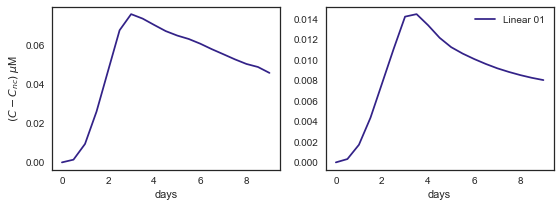

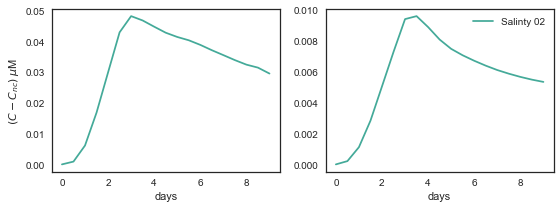

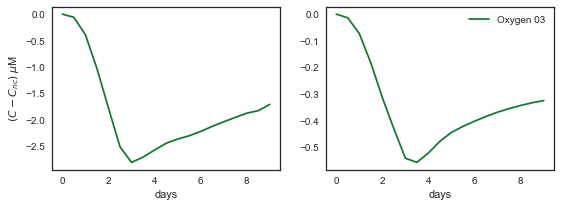

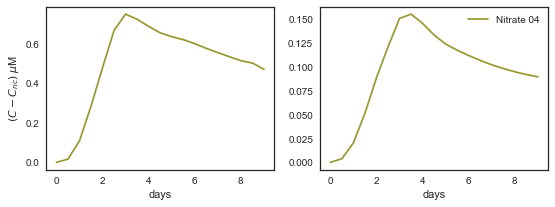

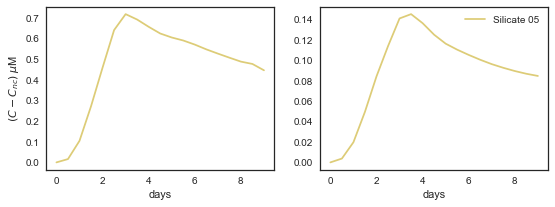

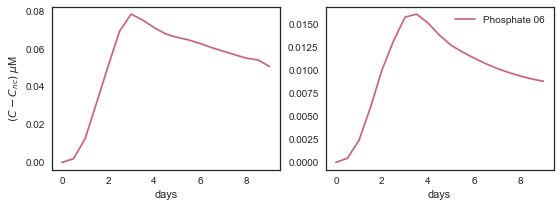

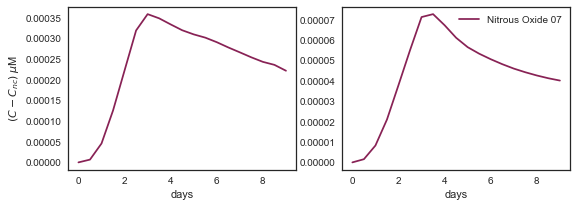

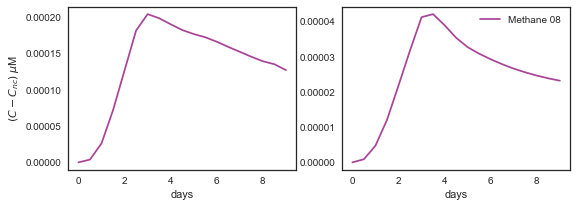

In [30]:
ptrA = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_8TR_BF2_AST/01_Ast03/ptracersGlob.nc')
ptrA_NoC = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_8TR_BF2_AST/02_Ast03_No_Cny/ptracersGlob.nc')
ptrB = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_8TR_BF4_BAR/01_Bar03/ptracersGlob.nc')
ptrB_NoC = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_8TR_BF4_BAR/02_Bar03_No_Cny/ptracersGlob.nc')

zsl = slice(0,8)
xslA = slice(xA_left, xA_right)
yslA = slice(yA_bot, yA_top)
xslB = slice(xB_left, xB_right)
yslB = slice(yB_bot, yB_top)

concA = [ptrA.Tr01.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
       ptrA.Tr02.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
       ptrA.Tr03.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
       ptrA.Tr04.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
       ptrA.Tr05.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
       ptrA.Tr06.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
       ptrA.Tr07.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z')*1E-3,
       ptrA.Tr08.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z')*1E-3] # units of nM to muM

concANoC = [ptrA_NoC.Tr01.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
           ptrA_NoC.Tr02.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
           ptrA_NoC.Tr03.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
           ptrA_NoC.Tr04.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
           ptrA_NoC.Tr05.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
           ptrA_NoC.Tr06.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z'),
           ptrA_NoC.Tr07.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z')*1E-3,
           ptrA_NoC.Tr08.isel(Z=zsl,X=xslA,Y=yslA).mean(dim='Z')*1E-3]

concB = [ptrB.Tr01.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
       ptrB.Tr02.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
       ptrB.Tr03.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
       ptrB.Tr04.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
       ptrB.Tr05.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
       ptrB.Tr06.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
       ptrB.Tr07.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z')*1E-3,
       ptrB.Tr08.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z')*1E-3]

concBNoC = [ptrB_NoC.Tr01.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
           ptrB_NoC.Tr02.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
           ptrB_NoC.Tr03.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
           ptrB_NoC.Tr04.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
           ptrB_NoC.Tr05.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
           ptrB_NoC.Tr06.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z'),
           ptrB_NoC.Tr07.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z')*1E-3,
           ptrB_NoC.Tr08.isel(Z=zsl,X=xslB,Y=yslB).mean(dim='Z')*1E-3]


for CA,CANoC,CB,CBNoC,col,lab in zip(concA, concANoC, concB, concBNoC, colours[:], labels[:]):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,3), sharex=True)

    #Astoria    
    difA_ts = (((CA-CANoC)).mean(dim='X')).mean(dim='Y')   
    ax1.plot(np.arange(len(difA_ts))/2.0, difA_ts, color=col, label=lab)
    
    #Barkley
    difB_ts = (((CB-CBNoC)).mean(dim='X')).mean(dim='Y')   
    ax2.plot(np.arange(len(difB_ts))/2.0, difB_ts, color=col, label=lab)

    ax2.legend(bbox_to_anchor=(1,1))
    ax1.set_xlabel('days')
    ax2.set_xlabel('days')
    ax1.set_ylabel('$(C-C_{nc})$ $\mu$M')
    plt.show()